In [24]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [25]:
from sklearn.ensemble import RandomForestClassifier #随机森林分类器

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 用于评估分类器性能的指标
from sklearn.metrics import classification_report, confusion_matrix #用于生成分类报告和混淆矩阵
import warnings #用于忽略警告信息
warnings.filterwarnings("ignore") # 忽略所有警告信息
# --- 1. 默认参数的随机森林 ---
# 评估基准模型，这里确实不需要验证集
print("--- 1. 默认参数随机森林 (训练集 -> 测试集) ---")
import time # 这里介绍一个新的库，time库，主要用于时间相关的操作，因为调参需要很长时间，记录下会帮助后人知道大概的时长
start_time = time.time() # 记录开始时间
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) # 在训练集上训练
rf_pred = rf_model.predict(X_test) # 在测试集上预测
end_time = time.time() # 记录结束时间

print(f"训练与预测耗时: {end_time - start_time:.4f} 秒")
print("\n默认随机森林 在测试集上的分类报告：")
print(classification_report(y_test, rf_pred))
print("默认随机森林 在测试集上的混淆矩阵：")
print(confusion_matrix(y_test, rf_pred))

--- 1. 默认参数随机森林 (训练集 -> 测试集) ---
训练与预测耗时: 0.8122 秒

默认随机森林 在测试集上的分类报告：
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1059
           1       0.79      0.30      0.43       441

    accuracy                           0.77      1500
   macro avg       0.78      0.63      0.64      1500
weighted avg       0.77      0.77      0.73      1500

默认随机森林 在测试集上的混淆矩阵：
[[1023   36]
 [ 309  132]]


In [26]:
import shap
import matplotlib.pyplot as plt

# 初始化 SHAP 解释器
explainer = shap.TreeExplainer(rf_model)

# 计算 SHAP 值（基于测试集），这个shap_values是一个numpy数组，表示每个特征对每个样本的贡献值
# 这里大家先知道这是个numpy数组即可，我们后面学习完numpy在来回头解读这个值
shap_values = explainer.shap_values(X_test) # 这个计算耗时

In [27]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [28]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [29]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [30]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [31]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [32]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [33]:
# 先运行之前预处理好的代码
import pandas as pd
import pandas as pd    #用于数据处理和分析，可处理表格数据。
import numpy as np     #用于数值计算，提供了高效的数组操作。
import matplotlib.pyplot as plt    #用于绘制各种类型的图表
import seaborn as sns   #基于matplotlib的高级绘图库，能绘制更美观的统计图形。
import warnings
warnings.filterwarnings("ignore")
 
 # 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
data = pd.read_csv('data.csv')    #读取数据


# 先筛选字符串变量 
discrete_features = data.select_dtypes(include=['object']).columns.tolist()
# Home Ownership 标签编码
home_ownership_mapping = {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
}
data['Home Ownership'] = data['Home Ownership'].map(home_ownership_mapping)

# Years in current job 标签编码
years_in_job_mapping = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
data['Years in current job'] = data['Years in current job'].map(years_in_job_mapping)

# Purpose 独热编码，记得需要将bool类型转换为数值
data = pd.get_dummies(data, columns=['Purpose'])
data2 = pd.read_csv("data.csv") # 重新读取数据，用来做列名对比
list_final = [] # 新建一个空列表，用于存放独热编码后新增的特征名
for i in data.columns:
    if i not in data2.columns:
       list_final.append(i) # 这里打印出来的就是独热编码后的特征名
for i in list_final:
    data[i] = data[i].astype(int) # 这里的i就是独热编码后的特征名



# Term 0 - 1 映射
term_mapping = {
    'Short Term': 0,
    'Long Term': 1
}
data['Term'] = data['Term'].map(term_mapping)
data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

# 最开始也说了 很多调参函数自带交叉验证，甚至是必选的参数，你如果想要不交叉反而实现起来会麻烦很多
# 所以这里我们还是只划分一次数据集
from sklearn.model_selection import train_test_split
X = data.drop(['Credit Default'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集



In [34]:
print("shap_values shape:", shap_values.shape)
print("shap_values[0] shape:", shap_values[0].shape)
print("shap_values[:, :, 0] shape:", shap_values[:, :, 0].shape)
print("X_test shape:", X_test.shape)

shap_values shape: (1500, 31, 2)
shap_values[0] shape: (31, 2)
shap_values[:, :, 0] shape: (1500, 31)
X_test shape: (1500, 31)


--- 1. SHAP 特征重要性条形图 ---


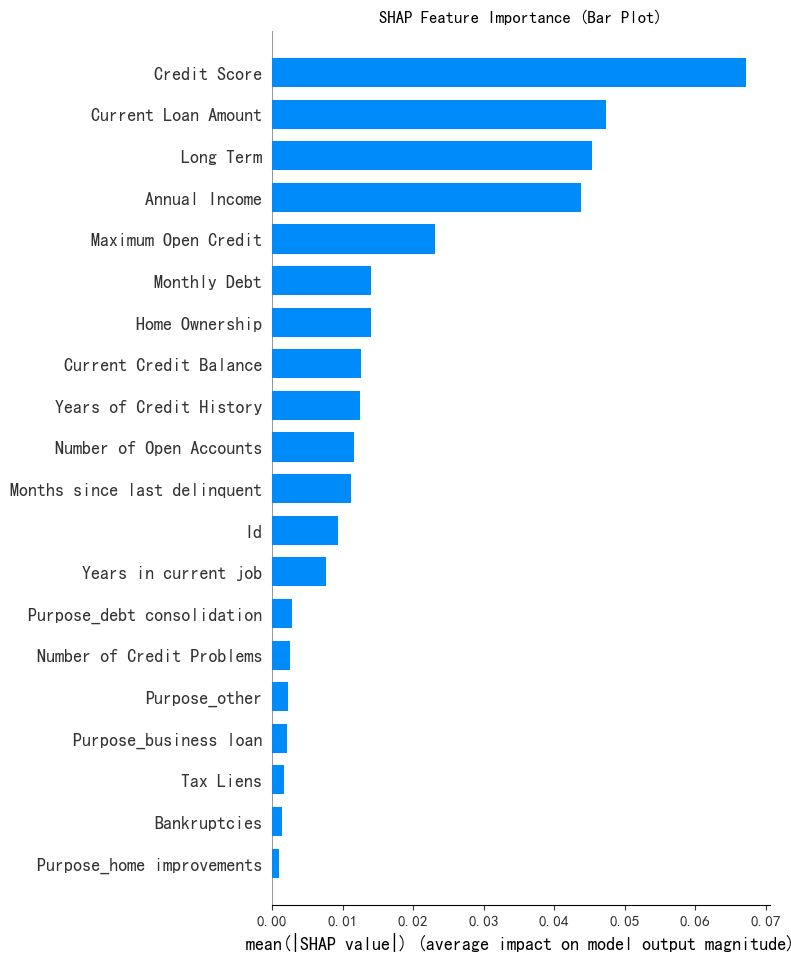

In [35]:
# --- 1. SHAP 特征重要性条形图 (Summary Plot - Bar) ---
print("--- 1. SHAP 特征重要性条形图 ---")
shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar",show=False)  #  这里的show=False表示不直接显示图形,这样可以继续用plt来修改元素，不然就直接输出了
plt.title("SHAP Feature Importance (Bar Plot)")
plt.show()

--- 2. SHAP 特征重要性蜂巢图 ---


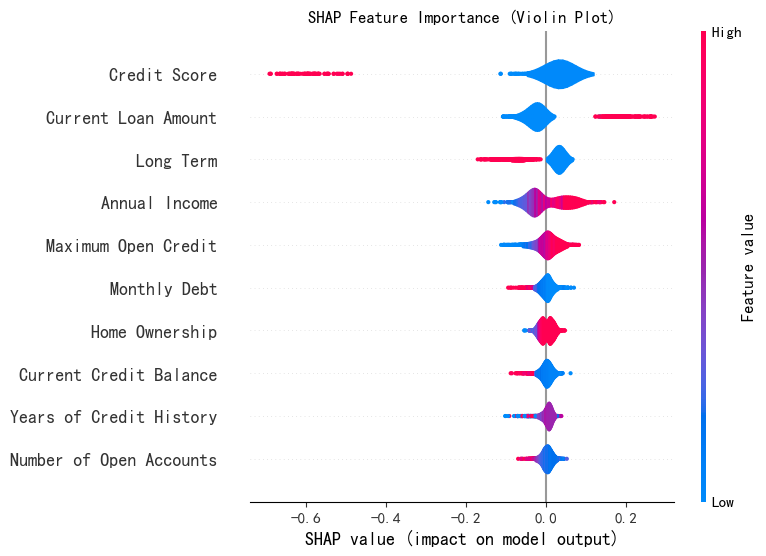

In [36]:
# --- 2. SHAP 特征重要性蜂巢图 (Summary Plot - Violin) ---
print("--- 2. SHAP 特征重要性蜂巢图 ---")
shap.summary_plot(shap_values[:, :, 0], X_test,plot_type="violin",show=False,max_display=10) # 这里的show=False表示不直接显示图形,这样可以继续用plt来修改元素，不然就直接输出了
plt.title("SHAP Feature Importance (Violin Plot)")
plt.show()
# 注意下上面几个参数，plot_type可以是bar和violin，max_display表示显示前多少个特征，默认是20个